In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint

from SVD import Metrics, SVDPredictor, LogisticSVD
from RecData import RecData

In [2]:
recs = pd.read_csv('data/recommendations.csv')

# Remove old ratings
recs = recs.sort_values(by=['date'], ascending=False)
recs.drop_duplicates(subset= ['app_id', 'user_id'], inplace=True) 

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.head()

Shape: (14585287, 3)


,app_id,is_recommended,user_id
2307118,1145360,True,2597309
1889941,1846380,True,4457610
7378728,1000360,True,1152924
7939199,262060,False,6207094
11381505,1657630,False,6372672


In [3]:
random.seed(42)
np.random.seed(42)

rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

del recs

print("Creating splits...")
train_data, test = rec_data.train_test_split(test_size=0.2)
print("First split done.")
train_data, val = train_data.train_test_split(test_size=0.2)
print("Done creating splits.")

Creating utility matrix...
Done utility matrix.
Creating splits...
First split done.
Done creating splits.


In [4]:
rec_data._num_users

6903784

In [ ]:
# random.seed(42)
# np.random.seed(42)

# rec_data = RecData()
# rec_data.create_from_dataframe(recs)
# rec_data.set_titles(titles)

# del recs

# print("Creating splits...")
# train_data, val, test = rec_data.leave_k_out_split(k=1)
# print("Done creating splits.")

In [5]:
del item_data
del titles

In [ ]:
EPOCHS = 5

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = LogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=20, epochs=EPOCHS, 
    learning_rate=0.1, C=0.1)
svd_predictor.fit(train_data.get_matrix(), validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

Epoch 0/Training error: 0.6931461361233392/Validation error: 0.6931471221402001/Time: 285.46 seconds


In [ ]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([svd_predictor, rec_data, train_data, val, test], file)
print("Done saving model.")

Saving model...


In [10]:
svd_predictor.continue_fit(5, early_stop=False)

Epoch 0/Training error: 0.6850771698268301/Validation error: 0.6931523836484671/Time: 143.36 seconds
Small change in validation error. Terminating training.


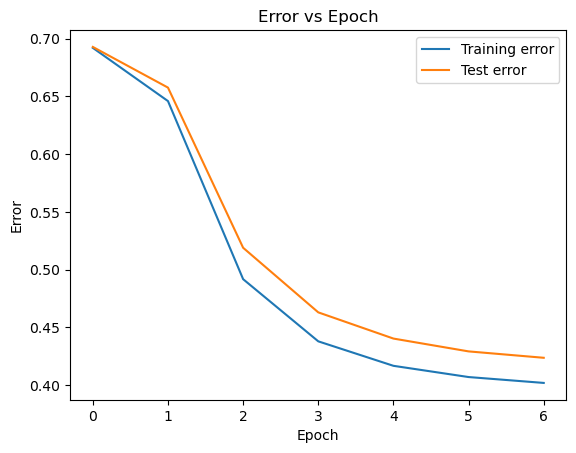

In [91]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

In [9]:
j = 2000
# Test top-n list for user j
top_n = svd_predictor.top_n(j, 20)
print("Predicted top n:")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = rec_data.top_n(j, 5000)
pprint([rec_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[(0.5006532961409336, 'Herald: An Interactive Period Drama - Book I & II'),
 (0.5005877704217542, "Heaven's Vault"),
 (0.5005860099990128, 'Castle Must Be Mine'),
 (0.5005798907204566, 'Vampire: The Masquerade - Bloodlines'),
 (0.5005739642150991, 'Crypto Miner Tycoon Simulator'),
 (0.5005685160895388, 'Close Combat: Last Stand Arnhem'),
 (0.5005516770586704, 'Card Quest'),
 (0.5005336698883699, "Flashpoint Campaigns: Red Storm Player's Edition"),
 (0.5005201141025901, 'Race Track Builder'),
 (0.5005096115313623, 'Archon Classic'),
 (0.500505730755452, 'Fate Seeker II'),
 (0.5004965433314732, "Delicious - Emily's Hopes and Fears"),
 (0.5004942210178936, 'Magical Girl Celesphonia'),
 (0.5004886654508258, 'Miss Neko 2'),
 (0.5004853858711612, 'Franchise Hockey Manager 8'),
 (0.5004821426643254, 'Wallace & Gromit’s Grand Adventures'),
 (0.5004703710144548, 'RPG Maker MZ'),
 (0.5004603364929225, 'Mount Your Friends 3D: A Hard Man is Good to Climb'),
 (0.5004568035105533, '

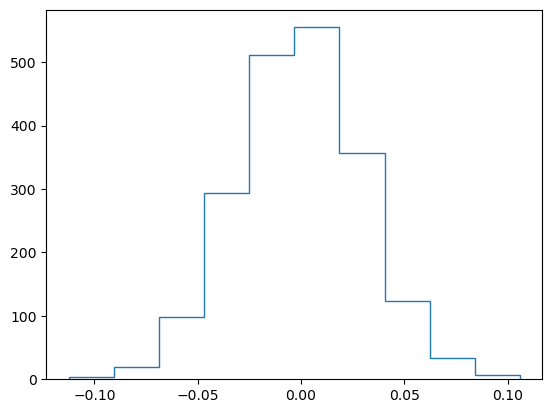

In [98]:
values, bins = np.histogram(svd_predictor._user_features[0, :])
plt.stairs(values, bins)
plt.show()

In [38]:
rec_data.search_title('mortal')

[('noel the mortal fate s1-7', 2130),
 ('mortal kombat x', 943),
 ('immortality', 833),
 ('mortal shell', 855),
 ('鬼谷八荒 tale of immortal', 1237),
 ('dark deception: monsters & mortals', 430),
 ('mortal online 2', 35),
 ('mortal kombat\xa011', 287)]

In [7]:
# prefs = [(606, 1), (1628, 1), (391, 0), (1330, 0), (500, 0), (709, 1), (840, 0), 
#          (58, 1), (456, 1), (153, 0), (158, 0), (1160, 0), (761, 0),
#                               (1771, 0), (544, 0), (312, 0), (277, 0)]
prefs = [(5, 1), (229, 1), (943, 0)]
pprint([(index, rec_data.index_to_title(index), pref) for index, pref in prefs])
prefs = rec_data.create_prefs(prefs)    

[(5, 'The Sims™ 4', 1), (229, 'The Sims™ 3', 1), (943, 'Mortal Kombat X', 0)]


In [8]:
svd_predictor._partial_batch_size = int(0)
start_time = time.time()
svd_predictor.partial_fit(prefs)
print("Completed partial fit in", time.time() - start_time, "seconds")

Epoch 0/Training error: 0.6930850198543101/Time: 93.09 seconds
Epoch 1/Training error: 0.6930850198543101/Time: 84.74 seconds
Epoch 2/Training error: 0.6930850198543101/Time: 82.23 seconds
Epoch 3/Training error: 0.6930850198543101/Time: 86.57 seconds
Epoch 4/Training error: 0.6930850198543101/Time: 88.3 seconds
Completed partial fit in 466.0883584022522 seconds


In [10]:
top_n = svd_predictor.top_n(train_data.get_matrix().shape[0], 20)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

Predicted top n
[(0.5005690261609175, 'Comanche 4'),
 (0.5005291595336794, 'Deepest Chamber: Resurrection'),
 (0.5004738247664933, 'Sakura Dungeon'),
 (0.5004697062596587, 'Orangeblood'),
 (0.5004486819119719, 'Aven Colony'),
 (0.5004402876062598, 'Neighbours from Hell Compilation'),
 (0.5004364248630278, "Adventure Time: Magic Man's Head Games"),
 (0.5004306438297483, 'Wayhaven Chronicles: Book One'),
 (0.5004269826471557, 'Enter The Backrooms'),
 (0.500426043840881, 'Relayer Advanced'),
 (0.5004228436675524, 'BBQ Simulator: The Squad'),
 (0.5004201418754849, 'ArcaniA'),
 (0.5004169997499192, 'B-17 Flying Fortress: The Mighty 8th'),
 (0.5004015826336186, 'EARTH DEFENSE FORCE: WORLD BROTHERS'),
 (0.5003991099924385, 'Tower of Ardia'),
 (0.5003988488670162, 'The Exorcist: Legion VR (Deluxe Edition)'),
 (0.5003959101001172, 'Vampire: The Masquerade — Parliament of Knives'),
 (0.5003888747324006, 'Gaia Project'),
 (0.500383673539515, 'Vampire: The Masquerade - Bloodlines'),
 (0.5003768706